<a href="https://colab.research.google.com/github/agarwalsoham993/Key-Frame-Extraction/blob/main/Key_frame_extractions_public_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

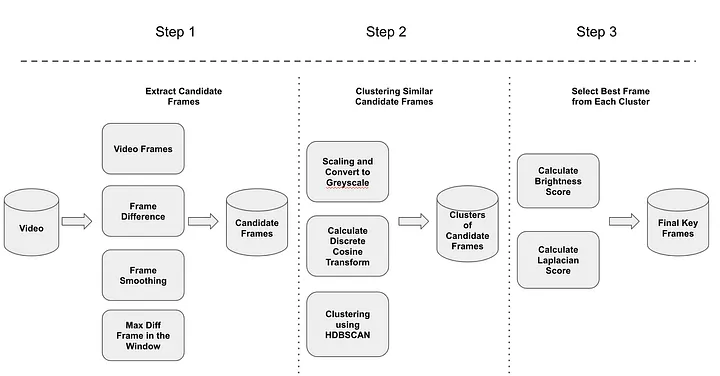

In [1]:
import cv2
import os
import sys
import time
import numpy as np
import logging
import argparse
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans
from skimage.filters.rank import entropy
from skimage.morphology import disk
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

class Configs:
    USE_LOCAL_MAXIMA = True
    len_window = 10
    max_frames_in_chunk = 2500
    window_type = "hanning"

class Frame:                                  #for referencing the frame
    def __init__(self, frame, sum_abs_diff):
        self.frame = frame
        self.sum_abs_diff = sum_abs_diff

class FrameExtractor(object):
    def __init__(self):
        self.USE_LOCAL_MAXIMA = Configs.USE_LOCAL_MAXIMA
        self.len_window = Configs.len_window
        self.max_frames_in_chunk = Configs.max_frames_in_chunk

    def __calculate_frame_difference(self, frame, curr_frame, prev_frame):
        if curr_frame is not None and prev_frame is not None:
            diff = cv2.absdiff(curr_frame, prev_frame)
            count = np.sum(diff)
            frame = Frame(frame, count)
            return count, frame
        return None

    def __process_frame(self, frame, prev_frame, frame_diffs, frames):
        # Using HSV/Grayscale for difference calculation
        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        curr_frame = grey

        frame_diff = self.__calculate_frame_difference(frame, curr_frame, prev_frame)

        if frame_diff is not None:
            count, frame = frame_diff
            frame_diffs.append(count)
            frames.append(frame)
        prev_frame = curr_frame

        return prev_frame, curr_frame

    def __extract_all_frames_from_video__(self, videopath):
        cap = cv2.VideoCapture(str(videopath))
        ret, frame = cap.read()
        i = 1
        while ret:
            curr_frame = None
            prev_frame = None
            frame_diffs = []
            frames = []
            for _ in range(0, self.max_frames_in_chunk):
                if ret:
                    prev_frame, curr_frame = self.__process_frame(frame, prev_frame, frame_diffs, frames)
                    i = i + 1
                    ret, frame = cap.read()
                else:
                    cap.release()
                    break
            yield frames, frame_diffs
        cap.release()

    def __smooth__(self, x, window_len, window=Configs.window_type):
        if x.ndim != 1: raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len: raise ValueError("Input vector needs to be bigger than window size.")
        if window_len < 3: return x
        if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
            raise ValueError("Window must be one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

        s = np.r_[2 * x[0] - x[window_len:1:-1], x, 2 * x[-1] - x[-1:-window_len:-1]]

        if window == "flat":
            w = np.ones(window_len, "d")
        else:
            w = getattr(np, window)(window_len)

        y = np.convolve(w / w.sum(), s, mode="same")
        return y[window_len - 1 : -window_len + 1]

    def __get_frames_in_local_maxima__(self, frames, frame_diffs):
        extracted_key_frames = []
        diff_array = np.array(frame_diffs)
        sm_diff_array = self.__smooth__(diff_array, self.len_window)
        frame_indexes = np.asarray(argrelextrema(sm_diff_array, np.greater))[0]

        for frame_index in frame_indexes:
            extracted_key_frames.append(frames[frame_index - 1].frame)
        return extracted_key_frames

    def extract_candidate_frames(self, videopath):
        extracted_candidate_key_frames = []
        frame_extractor_from_video_generator = self.__extract_all_frames_from_video__(videopath)

        for frames, frame_diffs in frame_extractor_from_video_generator:
            if self.USE_LOCAL_MAXIMA:
                extracted_candidate_key_frames_chunk = self.__get_frames_in_local_maxima__(frames, frame_diffs)
                extracted_candidate_key_frames.extend(extracted_candidate_key_frames_chunk)

        return extracted_candidate_key_frames

    def save_frame_to_disk(self, frame, file_path, file_name, file_ext):
        file_full_path = os.path.join(file_path, file_name + file_ext)
        cv2.imwrite(file_full_path, frame)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [7]:
class ImageSelector(object):                                            #HDBscan
    def __get_brighness_score__(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        _, _, v = cv2.split(hsv)
        sum_val = np.sum(v, dtype=np.float32)
        num_of_pixels = v.shape[0] * v.shape[1]
        return (sum_val * 100.0) / (num_of_pixels * 255.0)

    def __get_entropy_score__(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        entr_img = entropy(gray, disk(5))
        all_sum = np.sum(entr_img)
        num_of_pixels = entr_img.shape[0] * entr_img.shape[1]
        return (all_sum) / (num_of_pixels)

    def __variance_of_laplacian__(self, image):
        return cv2.Laplacian(image, cv2.CV_64F).var()

    def __prepare_cluster_sets__hdbscan(self, files):
        all_dst = []
        for img_file in files:
            img = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (256, 256))
            imf = np.float32(img) / 255.0
            dst = cv2.dct(imf)
            dst = dst[:16, :16]
            dst = dst.reshape((256))
            all_dst.append(dst)

        Hdbascan = hdbscan.HDBSCAN(min_cluster_size=2, metric='manhattan').fit(all_dst)
        labels = np.add(Hdbascan.labels_, 1)
        nb_clusters = len(np.unique(Hdbascan.labels_))

        files_clusters_index_array = []
        files_clusters_index_array_of_only_one_image = []

        for i in np.arange(nb_clusters):
            if i == 0:
                index_array = np.where(labels == i)
                files_clusters_index_array_of_only_one_image.append(index_array)
            else:
                index_array = np.where(labels == i)
                files_clusters_index_array.append(index_array)

        files_clusters_index_array = np.array(files_clusters_index_array, dtype=object)

        return np.array(files_clusters_index_array), files_clusters_index_array_of_only_one_image

    def __get_laplacian_scores(self, files, n_images):
        variance_laplacians = []
        for image_i in n_images:
            img_file = files[n_images[image_i]]
            img = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
            variance_laplacian = self.__variance_of_laplacian__(img)
            variance_laplacians.append(variance_laplacian)
        return variance_laplacians

    def __get_best_images_index_from_each_cluster__(self, files, files_clusters_index_array):
        filtered_items = []
        clusters = np.arange(len(files_clusters_index_array))

        for cluster_i in clusters:
            curr_row = files_clusters_index_array[cluster_i][0]
            n_images = np.arange(len(curr_row))
            variance_laplacians = self.__get_laplacian_scores(files, n_images)

            try:
                selected_frame_of_current_cluster = curr_row[np.argmax(variance_laplacians)]
                filtered_items.append(selected_frame_of_current_cluster)
            except:
                break
        return filtered_items

    def select_best_frames(self, input_key_frames, output_folder):
        filtered_images_list = []

        if len(input_key_frames) >= 1:
            files_clusters_index_array, files_clusters_index_array_of_only_one_image = self.__prepare_cluster_sets__hdbscan(input_key_frames)
            selected_images_index = self.__get_best_images_index_from_each_cluster__(input_key_frames, files_clusters_index_array)

            # Handle clusters with single images
            if files_clusters_index_array_of_only_one_image:
                 # Flatten the list structure if needed
                files_clusters_index_array_of_only_one_image = [item for t in files_clusters_index_array_of_only_one_image for item in t]
                if len(files_clusters_index_array_of_only_one_image) > 0:
                    files_clusters_index_array_of_only_one_image = files_clusters_index_array_of_only_one_image[0].tolist()
                    selected_images_index.extend(files_clusters_index_array_of_only_one_image)

            for index in selected_images_index:
                img = input_key_frames[index]
                filtered_images_list.append(img)

            # Save images of same clusters (Debug/Analysis)
            i = 0
            for images in files_clusters_index_array:
                path = os.path.join(output_folder, str(i))
                try:
                    if not os.path.isdir(output_folder): os.mkdir(output_folder)
                    if not os.path.isdir(path): os.makedirs(path)
                except OSError:
                    pass

                for image in images[0]:
                    cv2.imwrite(os.path.join(path, str(image)+'.jpeg'), input_key_frames[image])
                i += 1
        else:
            for img in input_key_frames:
                filtered_images_list.append(img)

        return filtered_images_list


In [3]:
INPUT_VIDEO_PATH = "videoplayback.mp4"
OUTPUT_FOLDER_CANDIDATES = "candidate_frames"
OUTPUT_FOLDER_FINAL = "final_key_frames"

In [4]:
base_dir = os.path.dirname(os.path.abspath(INPUT_VIDEO_PATH)) if os.path.dirname(INPUT_VIDEO_PATH) else "."
candidates_path = os.path.join(base_dir, OUTPUT_FOLDER_CANDIDATES)
final_path = os.path.join(base_dir, OUTPUT_FOLDER_FINAL)

if not os.path.isdir(candidates_path): os.makedirs(candidates_path)
if not os.path.isdir(final_path): os.makedirs(final_path)

In [5]:
start_time = time.time()
extractor = FrameExtractor()
candidate_imgs = extractor.extract_candidate_frames(INPUT_VIDEO_PATH)
for counter, img in enumerate(candidate_imgs):
    extractor.save_frame_to_disk(
        img,
        file_path=candidates_path,
        file_name="candidate_" + str(counter),
        file_ext=".jpeg",
    )
print(f"Extracted {len(candidate_imgs)} candidate frames in {time.time()-start_time} time.")

Extracted 1009 candidate frames in 45.65081024169922 time.


In [8]:
start_time = time.time()
selector = ImageSelector()
final_imgs = selector.select_best_frames(candidate_imgs, candidates_path)

for counter, img in enumerate(final_imgs):
    extractor.save_frame_to_disk(
        img,
        file_path=final_path,
        file_name="keyframe_" + str(counter),
        file_ext=".jpeg",
    )

print(f"Selected {len(final_imgs)} in  {time.time() - start_time} time---")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Selected 445 in  4.54671311378479 time---


https://github.com/varunmittal50/key_frame_extraction_public/tree/master